# Motion Coherence Experiment Analysis Flow

## Synchronising Psychophysical and EEG Trials

1. Import subject data information
2. Combine 3 condition files of each subject according to the session order
3. Mark invalid key press:
    * log files registered these as __key='space'__ or __'-'__, outputted here as __key=0__
4. Discard rejected trials at Artefact Rejection 1 & 2
5. Mark trials that are not valid according to Reaction Time criteria:
    * AVG-2SD > RT > AVG + 2SD
6. Write the new data file in .csv format and save it in the data folder:
    * fname: **{*behavioural_pointer*}_subdatbhv.csv**
7. Register following variables in a .csv file:
    * *info_sxnstats.csv*
    * sub_no, sub_name, bhv_ptr, eeg_ptr, qTrlRej, qTrlVld, qTrlVldKey, qTrlVldRT

In [ ]:
import MotionCoherence as mc
dat_path = '/Users/mertozkan/Documents/Psyc161FinalProject/MotionCoherence/data'
mc.synchronize_behavioural_data_mc(dat_path)

## Behavioural Data Analysis

### Data Log for Bayesian Curve Fitting
1. __Read each '{}_subdatbhv.csv' file__
2. __Separate each condition 3x6 (Motion Type x Coherence Level)__
3. __Compute number of correct responses for each condition__
4. __Write in a .csv file in the following format:__ 
    * sub_no, cond_no, coh_lvl, qOK, qTrl
    * *datbhv_pfit_qOk.csv*
5. __Compute number of responses in one of the directions for each condition__
6. __Write in a .csv file in the following format:__ *Negative conditions denote for the other direction*
    * sub_no, cond_no, coh_lvl, key1, qTrl
    * *datbhv_pfit_qKey1.csv*
7. __Register the index number of valid and correct trials in another .csv file:__
    * sub_no, trl_vld, trl_ok
    * *info_trials.csv*

In [ ]:
import MotionCoherence as mc
dat_path = '/Users/mertozkan/Documents/Psyc161FinalProject/MotionCoherence/data'
mc.create_data_forPsyPhysFit_mc(dat_path)

### Creating Curve Fitting Data
I created another package called PsyPhysFit for curve fitting. It fits a curve using bayesfit module. However, I use altair to plot the curves since bayesfit module was not producing good figures. Through __plot_psyphysfit__ function I allow users to determine properties such as axis limits, color schemes etc. Moreover, the users can decide which plot to show (fitted curve, data points, threshold) and plot multiple curves in the same figures.

1. Create a dictionary where the curve fitting estimates are registered.
2. Import the data from _datbhv_pfit_qOk.csv_
3. Fit the curve for each participant's data using __ppf.psyfit_estimates__
4. Write estimates and data itself in the dictionary.
5. Write the dictionary in the json format.
6. Save the json data in _dat_dePsyPhysFit_MC.txt_



In [ ]:
import MotionCoherence as mc
import numpy as np
import os
import psyphysfit as ppf
import json

estx = {}
estx['Header'] = 'Motion Coherence, PsyPhysFit Results'
estx['Author'] = 'Mert Ozkan'
estx['Filename'] = 'dat_dePsyPhysFit_MC.txt'
estx['Description'] = '''Psychophysical  Curve Fitting Estimates for each participant is registered in json files.'''
estx['Format'] = {
    'Header': '',
    'Description': '',
    'Author': '',
    'Format': '',
    'Filename': '',
    'Data':{
        'SubN':{
            'MotType':{
                'Intensity': '',
                'qOk': '',
                'qTrl': '',
            }
        }
    },
    'Estimate':{
        'SubN':{
            'MotType':{
                'est':{
                    'x': '',
                    'y': '',
                },
                'threshold': '',
                'parameters': '',
                'options':{
                    'nafc': '',
                    'sigmoid_type': '',
                    'threshold': '',
                    'estimate_type': '',
                    'est_x_lim': '',
                    'est_x_precision': ''
                }
            }
        }
    }
}

estx['Estimate'] = dict()
estx['Data'] = dict()

dat_path = '/Users/mertozkan/Documents/Psyc161FinalProject/MotionCoherence/data'

dat =  mc.importfromstandardcsv_moz(os.path.join(dat_path,'datbhv_pfit_qOk.csv'),whType='float')
sub_no, mot, coh, qOk, qTrl = mc.array2tupleofvectors(dat)

mot_tipx = ('Translational', 'Radial', 'Rotational')
for whSub in np.unique(sub_no).astype(int):
    estx['Data'][f'Sub{whSub}'] = dict()
    estx['Estimate'][f'Sub{whSub}'] = dict()
    dat_sub = sub_no==whSub
    for whMot in np.unique(mot).astype(int):
        
        estx['Data'][f'Sub{whSub}']['{}'.format(mot_tipx[whMot])] = dict()
        dat_mot = mot==whMot
        
        currTrl = np.logical_and(dat_sub, dat_mot)
        
        currDat = np.transpose(
            np.array(
                (coh[currTrl],qOk[currTrl], qTrl[currTrl])
            )
        )
        
        estx['Estimate'][f'Sub{whSub}']['{}'.format(mot_tipx[whMot])] = ppf.psyfit_estimates(currDat, threshold=.75)
        estx['Data'][f'Sub{whSub}']['{}'.format(mot_tipx[whMot])]['Intensity'] = list(currDat[:,0])
        estx['Data'][f'Sub{whSub}']['{}'.format(mot_tipx[whMot])]['qOk'] = list(currDat[:,1])
        estx['Data'][f'Sub{whSub}']['{}'.format(mot_tipx[whMot])]['qTrl'] = list(currDat[:,2])
    
        
json_estx = json.dumps(estx,indent=3)

dat_path = '/Users/mertozkan/Documents/Psyc161FinalProject/MotionCoherence/data'

f = open(os.path.join(dat_path,estx['Filename']),'w')
f.write(json_estx)
f.close()

### Plot Fitted Curves using altair:

Plot multiple psychophysical curves in the same figure.

1. Import data from json file _dat_dePsyPhysFit_MC.txt_
2. Create PsyPhysFitObject for each fitted curve (Subjects x Motion Types)
3. Plot each figure using __plot_psyphysfit__ function


In [3]:
import altair as alt
from functools import reduce
import json
import psyphysfit as ppf
import os

alt.renderers.enable('notebook')

dat_path = '/Users/mertozkan/Documents/Psyc161FinalProject/MotionCoherence/data'
f_name = os.path.join(dat_path,'dat_dePsyPhysFit_MC.txt')
f = open(f_name,'r')
estx = json.loads(f.read())

pltx = []
mot_tipx = ('Translational','Radial','Rotational')
for whSub in estx['Estimate'].keys():
    sub_pltx = []
    for whMot in mot_tipx:
        currEst = estx['Estimate'][whSub][whMot]
        currDat = estx['Data'][whSub][whMot]
        sub_pltx.append(ppf.PsyPhysFitObject(currDat,currEst))
    pltx.append(ppf.plot_psyphysfit(sub_pltx,
                                x_label='Coherence Level',
                                y_label='Proportion of Correct Trials',
                                x_lim=[0, 1],
                                y_lim=[.5, 1],
                                c_label='Motion Type',
                                c_levels=mot_tipx,
                                include_threshold=True,
                                include_datapoints=True,
                                title=whSub
                               ))
    chart = reduce(lambda x, y: x|y, pltx)


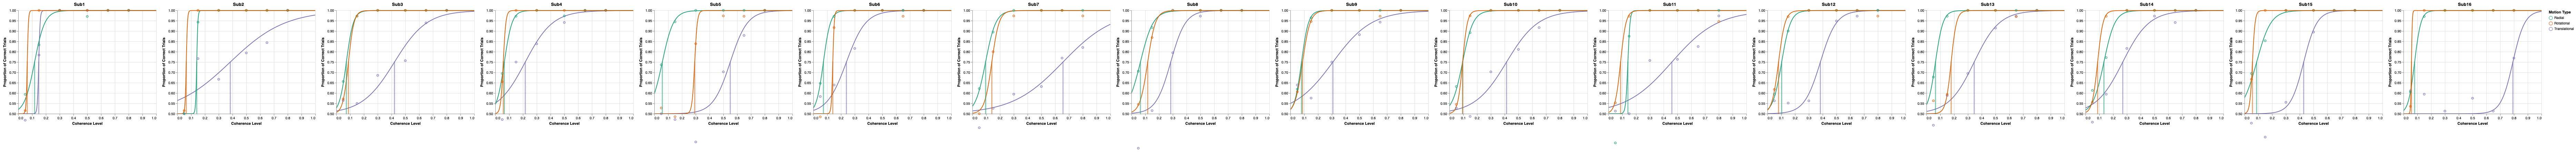

In [4]:
chart.display()